# Imitation Learning

## Objective: Fly balloon to a target location.

Imitation learning is a paradigm where an agent learns to mimic an **expert's behavior** instead of learning purely from trial-and-error rewards (e.g., reinforcement learning).

The simplest common approach is called "**behavior cloning**" (BC). It treats the expert's demonstrations as training data samples; train a policy using the expert's input(state) and output(action) pairs via supervised learning. However, BC often fails because the policy is only trained on states the expert visited, so if it ever drifts off that trajectory, it encounters states that the policy doesn't know what to do.

**[DAgger (Dataset Aggregation)](https://arxiv.org/pdf/1011.0686)** is an interactive imitation learning algorithm that deals with the issue above. The key idea is to keep utilizing the expert's knowledge during training and gradually expand the training data to include those "off-course" states. Instead of training the policy by cloning the expert's behavior, DAgger iteratively refines the policy:

1. After initial training on expert data (behavior cloning), execute the policy in the environment. (Policy rollout)
2. Store all the states the policy visits (it may include "bad" states).
3. Query the expert for the correct action in each of those states. (Expert labeling)
4. Aggregate these new state-action pairs into the training dataset.
5. Update the policy on this expanded dataset (so it knows what to do in new states).
6. Repeat this process.

Although DAgger requires querying the expert online, it improves behavior cloning by training on a dataset that better resembles the observations the trained policy is likely to encounter. [(Reference)](https://imitation.readthedocs.io/en/latest/algorithms/dagger.html#:~:text=DAgger%20,requires%20querying%20the%20expert%20online)

## For Colab users

In [1]:
## Colab users ##

# Clone the repository
import os

git_path = '/content/balloon-outreach'
if os.path.exists(git_path):
    print("✅ Found:", git_path)
else:
    print("❌ Not found:", git_path)
    !git clone https://github.com/sdean-group/balloon-outreach.git
    %cd balloon-outreach
    !git checkout main

❌ Not found: /content/balloon-outreach
Cloning into 'balloon-outreach'...
remote: Enumerating objects: 1318, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1318 (delta 109), reused 116 (delta 89), pack-reused 1165 (from 1)
Receiving objects: 100% (1318/1318), 60.11 MiB | 15.93 MiB/s, done.
Resolving deltas: 100% (835/835), done.
/content/balloon-outreach
Already on 'main'
Your branch is up to date with 'origin/main'.


In [2]:
# Install required packages
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.0/268.0 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.4 MB/s eta 0:00:00
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268067 sha256=f94214316060c17932354ef820d06cec18c0cea8b60cfc4736839dc48ada45ff
  Stored in directory: /root/.cache/pip/wheels/17/3c/41/2bc89719586c2a5c53e9a527daa76a968a1288315c1ae2d904
Successfully built reverse_geocoder
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.3.1
    Uninstalling xarray-2025.3.1:
      Successfully uninstalled xarray-2025.3.1


In [3]:
## Colab users ##

import sys
sys.path.append('/content/balloon-outreach/')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, radians
from datetime import datetime
from env.ERA_wind_field import WindField

In [5]:
from google.colab import drive
import gdown
import os

# 1. Mount your Drive
drive.mount('/content/drive')

# 2. Check existence
if os.path.exists('/content/drive/My Drive/era5_data.nc'):
    print("✅ Found:", '/content/drive/My Drive/era5_data.nc')
    datapath = '/content/drive/My Drive/era5_data.nc'

elif os.path.exists("/content/balloon-outreach/era5_data.nc"):
    print("✅ Found:", "/content/balloon-outreach/era5_data.nc")
    datapath = "/content/balloon-outreach/era5_data.nc"

else:
    print("❌ Not found")
    # Download ERA5 data
    file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
    url = f"https://drive.google.com/uc?id={file_id}"
    output = "era5_data.nc"
    gdown.download(url, output, quiet=False)
    datapath = "/content/balloon-outreach/era5_data.nc"


Mounted at /content/drive
✅ Found: /content/drive/My Drive/era5_data.nc


## For locals users

In [ ]:
# !pip install -r requirements-local.txt

In [ ]:
# ## local users ##

# import xarray as xr
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# import time
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# from math import cos, radians
# from datetime import datetime
# from env.ERA_wind_field import WindField

In [ ]:
# ## local users ##

# import os
# import gdown

# # 1. Construct the full path to your file
# datapath = 'era5_data.nc'

# # 3. Check existence
# if os.path.exists(datapath):
#     print("✅ Found:", datapath)
# else:
#     print("❌ Not found:", datapath)
#     # Download ERA5 data
#     file_id = "1Y5ocrCH0TVf9ZDkVGaJ03ftUrtKEVxIf"
#     url = f"https://drive.google.com/uc?id={file_id}"
#     output = "era5_data.nc"
#     gdown.download(url, output, quiet=False)


## Import Packages

In [6]:
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time

from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgentWithCostFunction, MPPIAgent
from utils.learning_util import run_expert_episode, evaluate_policy, train_one_epoch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Setup Environment

In [7]:
ds          = xr.open_dataset(datapath, engine="netcdf4")
start_time  = dt.datetime(year=2024, month=7, day=1, hour=0, minute=0)


#This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0

target_lat = 77.3
target_lon = -80.5
target_alt = 12.0

time_step = 120 #120 seconds
objective = 'target'

env = BalloonERAEnvironment(ds=ds,
                            start_time=start_time,
                            initial_lat=initial_lat,
                            initial_lon=initial_lon,
                            initial_alt=initial_alt,
                            target_lat=target_lat,
                            target_lon=target_lon,
                            target_alt=target_alt,
                            objective=objective,
                            dt=time_step,
                            viz=False)

WindField initialized with noise enabled: True


## Define policy

In [8]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim=21, hidden_dim=64, output_dim=1):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*2)
        self.ln1 = nn.LayerNorm(hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.tanh(x)

# Initialize policy network and optimizer
policy = PolicyNet()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

## Behavior Cloning to pretrain our policy

In [9]:
# Parameters for MPPI agent

max_steps = int(1440/(time_step/60)) #1 day

num_samples=10
acc_bounds= (-0.1, 0.1)
noise_std = 0.1
num_iterations=1
temperature=10
horizon = 10

# Define expert, run an episode from an expert, and collect its behavior.

expert = MPPIAgentWithCostFunction(target_lat=target_lat,
                                   target_lon=target_lon,
                                   target_alt=target_alt,
                                   num_samples=num_samples,
                                   acc_bounds= acc_bounds,
                                   noise_std=noise_std,
                                   num_iterations=num_iterations,
                                   temperature=temperature,
                                   horizon=horizon,
                                   visualize=False,
                                   objective=objective)

env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=100)
expert_total_reward_list = []
expert_states_list = []
expert_actions_list = []
expert_plot_fnms_list = []
num_iter = 3
for i in range(num_iter):
    expert_total_reward, expert_states_np, expert_actions_np, fnm = run_expert_episode(env, expert, max_steps=max_steps, dt=time_step, policy_name=f'expert_{i+1}')
    expert_total_reward_list.append(expert_total_reward)
    expert_states_list.append(expert_states_np)
    expert_actions_list.append(expert_actions_np)
    expert_plot_fnms_list.append(fnm)

initial_expert_states_np = np.concatenate(expert_states_list)
initial_expert_actions_np = np.concatenate(expert_actions_list)

Collected 720 state-action pairs from expert.
Initial position: [np.float64(42.6), np.float64(-76.5)], Target position: [77.3, -80.5], End position: [np.float64(77.1), np.float64(-80.7)], Distance: 22.533616647539322 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 10
Collected 720 state-action pairs from expert.
Initial position: [np.float64(42.6), np.float64(-76.5)], Target position: [77.3, -80.5], End position: [np.float64(77.1), np.float64(-80.6)], Distance: 11.703635446228343 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 10
Collected 720 state-action pairs from expert.
Initial position: [np.float64(42.6), np.float64(-76.5)], Target position: [77.3, -80.5], End position: [np.float64(77.1), np.float64(-80.6)], Distance: 11.703635446228343 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 10


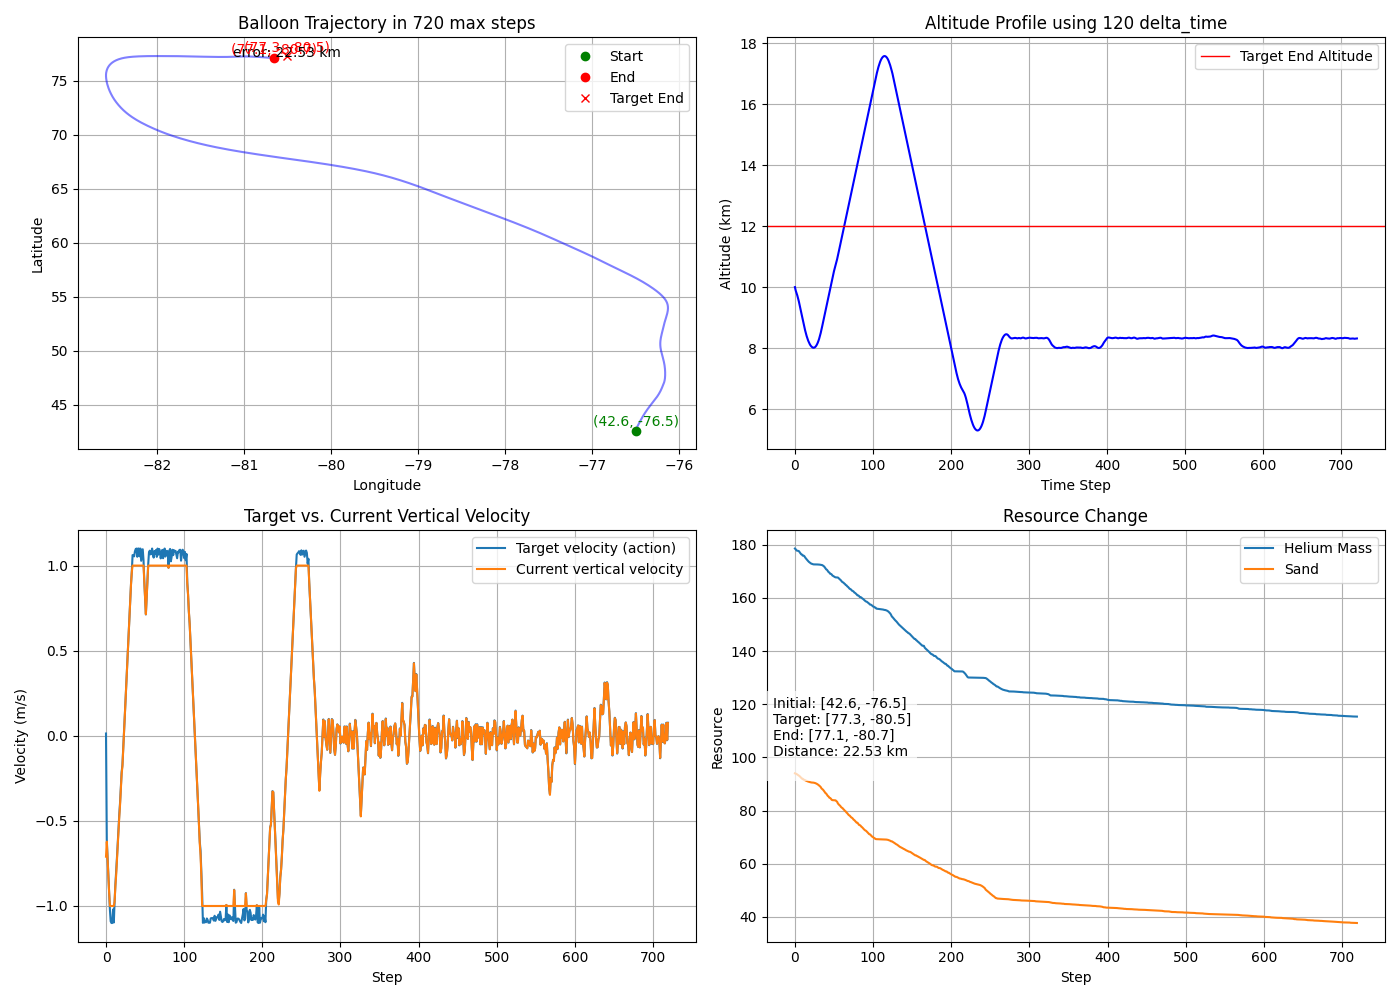

In [10]:
from IPython.display import Image, display
display(Image(filename=expert_plot_fnms_list[0]))

In [11]:
print(expert_total_reward_list)
expert_avg_total_reward = sum(expert_total_reward_list)/len(expert_total_reward_list)
print(f"Expert Trajectory reward in average: {expert_avg_total_reward:.2f}")

[np.float64(-8207.753758917974), np.float64(-8162.619426336661), np.float64(-8166.2413297168905)]
Expert Trajectory reward in average: -8178.87


### Initial Dataset & DataLoader Construction

In [12]:
# Convert to pytorch tensors
states_tensor = torch.from_numpy(initial_expert_states_np).float()               # shape (N, 21)
actions_tensor = torch.from_numpy(initial_expert_actions_np).float()             # shape (N, 1)

# Construct TensorDataset and DataLoader
dataset = TensorDataset(states_tensor, actions_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

### Pretrain our policy with Behavior Cloning

→ policy is in training mode
Epoch 1/5 — Avg Loss: 0.153884 

→ policy is in training mode
Epoch 2/5 — Avg Loss: 0.068690 

→ policy is in training mode
Epoch 3/5 — Avg Loss: 0.032566 

→ policy is in training mode
Epoch 4/5 — Avg Loss: 0.026348 

→ policy is in training mode
Epoch 5/5 — Avg Loss: 0.023233 



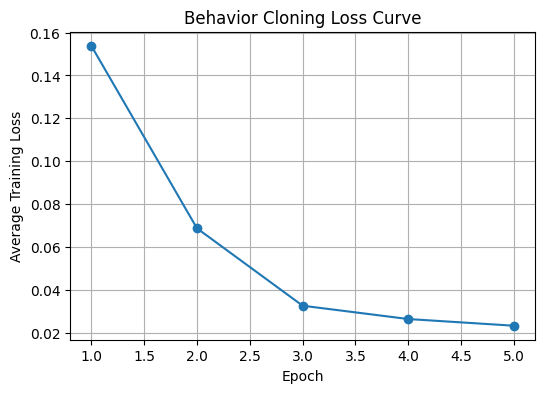

In [13]:
num_epochs = 5
losses = []
for epoch in range(num_epochs):
    avg_loss = train_one_epoch(loader, policy, optimizer, loss_fn)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.6f} \n")

# plot the loss curve from initial training (behavior cloning)
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Behavior Cloning Loss Curve')
plt.grid(True)
plt.show()

## DAgger Iterations

In [14]:
# === DAgger Iterations using DataLoader ===

# Parameters
dagger_iterations       = 3
episodes_per_iteration  = 1
train_epochs_per_iter   = 5
batch_size              = 64

# Start from initial BC dataset
states_np  = initial_expert_states_np.copy()   # (N0, 21)
actions_np = initial_expert_actions_np.copy()  # (N0,)

plot_fnms_list = []

for it in range(dagger_iterations):
    new_states = []
    new_actions = []

    # 1. Collect new data by rolling out current policy
    for ep in range(episodes_per_iteration):
        start = time.time()
        state = env.reset()
        for step in range(max_steps):
            # Student policy action
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            action_pred  = policy(state_tensor).item()

            # Record state & expert correction
            new_states.append(state)
            expert_act = expert.select_action(state, env, step)
            new_actions.append(expert_act)

            # Step environment with student action
            state, _, done, info = env.step(action_pred)
            if done:
                print(f"\nEpisode terminated: {info}")
                break
        end = time.time()
        print(f"Episode {ep+1}/{episodes_per_iteration} in DAgger Iteration {it+1}/{dagger_iterations} is done. \n Time: {end-start:.2f} seconds")


    # 2. Append new data to the NumPy arrays
    new_states_np  = np.array(new_states, dtype=np.float32)
    new_actions_np = np.array(new_actions, dtype=np.float32)
    states_np  = np.concatenate([states_np,  new_states_np], axis=0)
    actions_np = np.concatenate([actions_np, new_actions_np], axis=0)

    # 3. Rebuild dataset & loader
    states_tensor  = torch.from_numpy(states_np).float()
    actions_tensor = torch.from_numpy(actions_np).float()
    dataset = TensorDataset(states_tensor, actions_tensor)
    loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 4. Train on the aggregated dataset
    print(f"\n--- DAgger Iteration {it+1}/{dagger_iterations} Training ---")
    iter_losses = []
    for epoch in range(train_epochs_per_iter):
        avg_loss = train_one_epoch(loader, policy, optimizer, loss_fn)
        iter_losses.append(avg_loss)
        print(f" Iter {it+1} Epoch {epoch+1}/{train_epochs_per_iter} — Avg Loss: {avg_loss:.6f}")

    # 5. Evaluate policy
    env.wind_field.disable_noise()
    # env.wind_field.enable_noise(noise_seed=100)
    total_reward, plot_fnm = evaluate_policy(
        env,
        policy,
        objective,
        max_steps=max_steps,
        policy_name=f'DAgger_trained_policy_{it+1}',
        expert_avg_total_reward=expert_avg_total_reward
    )
    plot_fnms_list.append(plot_fnm)
    print(f" After DAgger Iter {it+1}, Total Reward = {total_reward:.2f}")


Episode 1/1 in DAgger Iteration 1/3 is done. 
 Time: 318.83 seconds

--- DAgger Iteration 1/3 Training ---
→ policy is in training mode
 Iter 1 Epoch 1/5 — Avg Loss: 0.016747
→ policy is in training mode
 Iter 1 Epoch 2/5 — Avg Loss: 0.017406
→ policy is in training mode
 Iter 1 Epoch 3/5 — Avg Loss: 0.017986
→ policy is in training mode
 Iter 1 Epoch 4/5 — Avg Loss: 0.013882
→ policy is in training mode
 Iter 1 Epoch 5/5 — Avg Loss: 0.013862
→ policy is in evaluation mode
Total reward obtained from current policy: -9096.74
Expert policy reward - Current policy reward: 917.87
Initial position: [np.float64(42.6), np.float64(-76.5)], Target position: [77.3, -80.5], End position: [np.float64(77.2), np.float64(-81.4)], Distance: 100.09067978022453 km
 After DAgger Iter 1, Total Reward = -9096.74
Episode 1/1 in DAgger Iteration 2/3 is done. 
 Time: 319.06 seconds

--- DAgger Iteration 2/3 Training ---
→ policy is in training mode
 Iter 2 Epoch 1/5 — Avg Loss: 0.013205
→ policy is in trainin

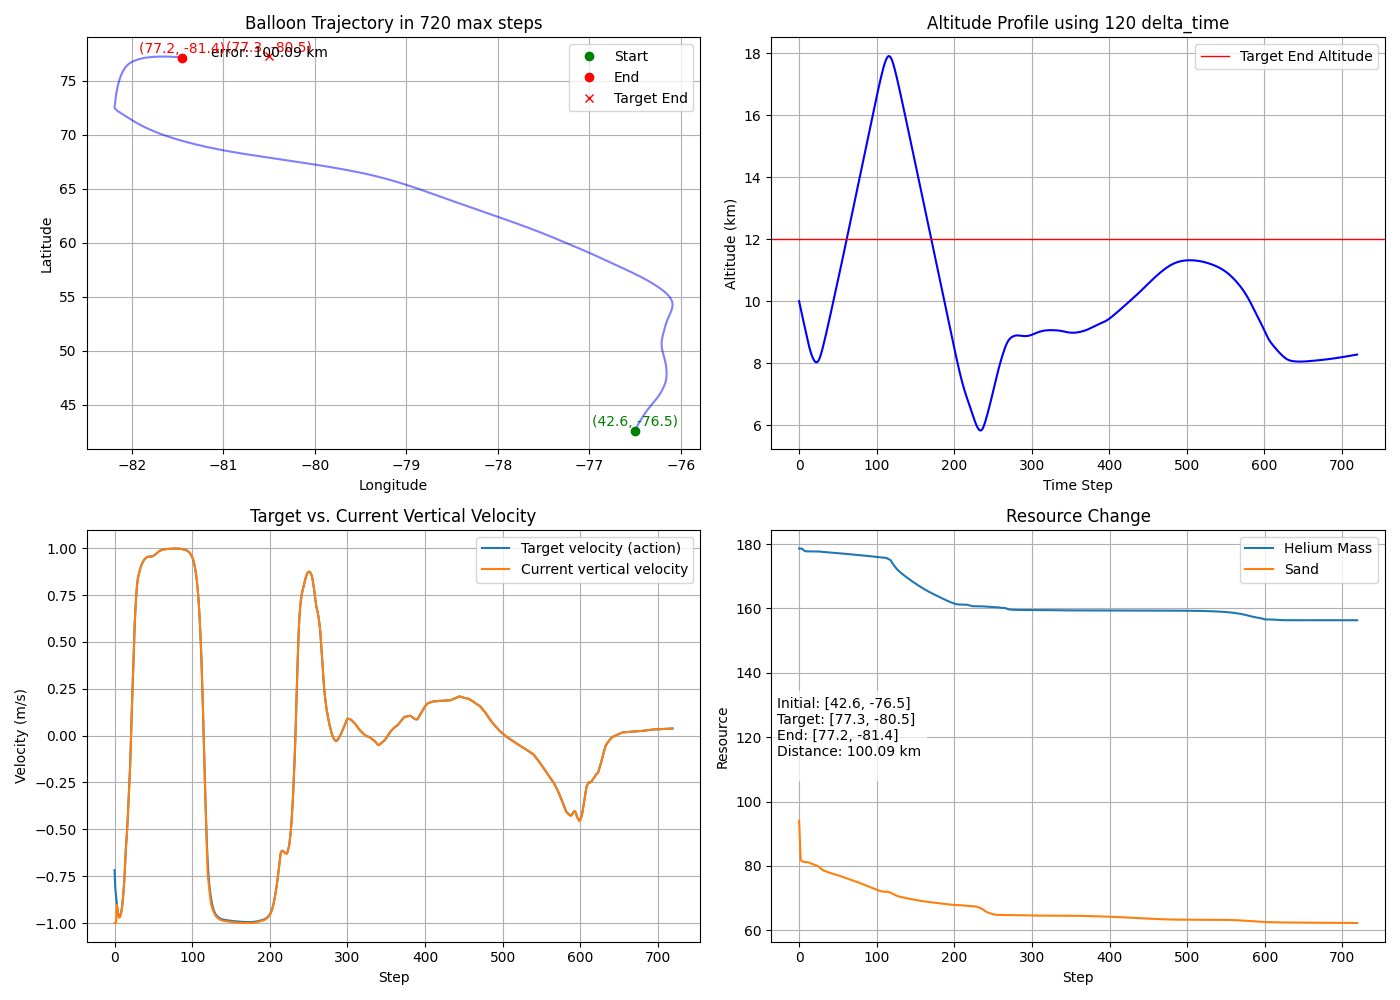

In [15]:
display(Image(filename=plot_fnms_list[0]))